In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import heapq
import cv2
import osmnx as ox
import networkx as nx
import time
from tabulate import tabulate
from math import radians, cos, sqrt


Lấy dữ liệu từ OSM 

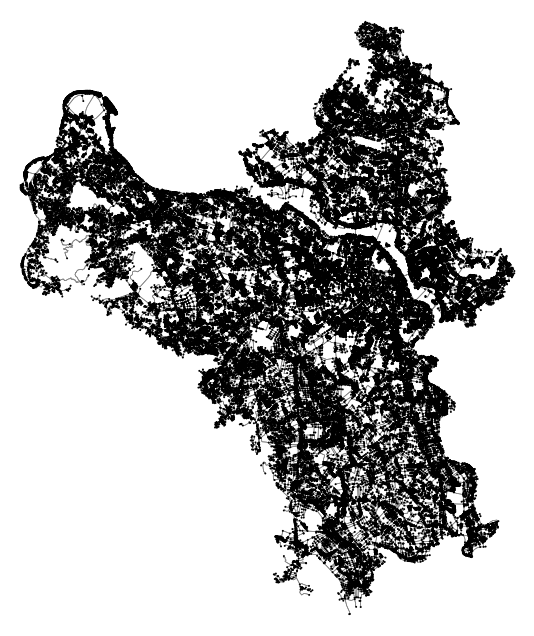

MultiDiGraph with 163099 nodes and 400832 edges
84806187 → 5710236733, key = 0, data = {'osmid': 600537341, 'highway': 'residential', 'oneway': False, 'reversed': False, 'length': 45.45006118107132}
84806187 → 84806193, key = 0, data = {'osmid': 179477523, 'highway': 'primary', 'lanes': '2', 'name': 'Đường Nguyễn Khoái', 'oneway': False, 'reversed': False, 'length': 261.851978005213, 'geometry': <LINESTRING (105.88 20.966, 105.88 20.966, 105.88 20.966, 105.88 20.966, 105...>}
84806187 → 4023430891, key = 0, data = {'osmid': 179477523, 'highway': 'primary', 'lanes': '2', 'name': 'Đường Nguyễn Khoái', 'oneway': False, 'reversed': True, 'length': 321.5038130006379, 'geometry': <LINESTRING (105.88 20.966, 105.88 20.966, 105.879 20.966, 105.879 20.966, 1...>}
84806193 → 440776411, key = 0, data = {'osmid': 179477523, 'highway': 'primary', 'lanes': '2', 'name': 'Đường Nguyễn Khoái', 'oneway': False, 'reversed': False, 'length': 30.593060608230815, 'geometry': <LINESTRING (105.882 20.967, 105

In [5]:

place_name = " Thành phố Hà Nội, Việt Nam"

G = ox.graph_from_place(place_name, network_type="drive")

fig, ax = ox.plot_graph(G, node_size=2, edge_linewidth=0.5, bgcolor="white", node_color="black", edge_color="gray")

print(G)
edges = list(G.edges(data=True, keys=True))[:5]
for u, v, k, data in edges:
    print(f"{u} → {v}, key = {k}, data = {data}")

print(edges[:5])


Đồ thị từ đa giác kết hợp có: 21306 nodes, 50237 edges


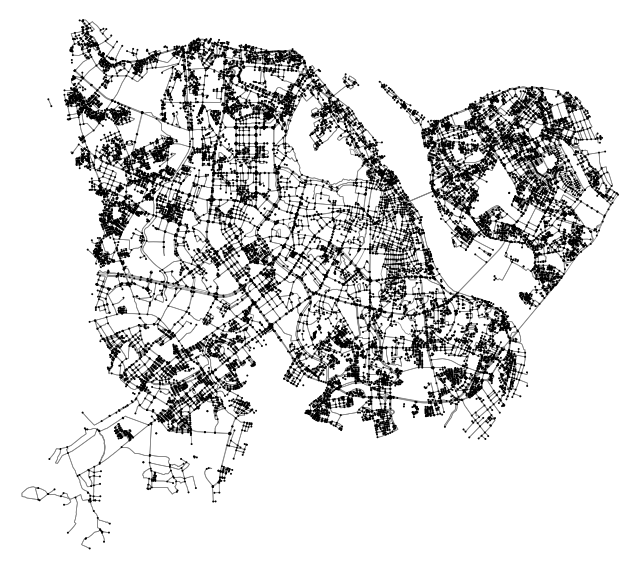

In [12]:
import osmnx as ox
import networkx as nx
import geopandas as gpd # Cần import geopandas nếu dùng gdf.buffer
from shapely.ops import unary_union # Để kết hợp các polygon (nếu cần)

# Danh sách các quận nội thành Hà Nội bạn muốn lấy dữ liệu
list_of_districts_queries = [ # Đổi tên biến để rõ ràng hơn
    "Ba Đình District, Hanoi, Vietnam", # Thêm "District" để tăng độ chính xác
    "Hoàn Kiếm District, Hanoi, Vietnam",
    "Tây Hồ District, Hanoi, Vietnam",
    "Cầu Giấy District, Hanoi, Vietnam",
    "Đống Đa District, Hanoi, Vietnam",
    "Hai Bà Trưng District, Hanoi, Vietnam",
    "Hoàng Mai District, Hanoi, Vietnam",
    "Thanh Xuân District, Hanoi, Vietnam",
    "Long Biên District, Hanoi, Vietnam",
    "Nam Từ Liêm District, Hanoi, Vietnam",
    "Bắc Từ Liêm District, Hanoi, Vietnam",
    "Hà Đông District, Hanoi, Vietnam"
]

network_type = 'drive'
buffer_meters = 500 # Khoảng buffer, ví dụ 500 mét

polygons = []
for query in list_of_districts_queries:
    try:
        # Lấy geometry của quận
        gdf = ox.geocode_to_gdf(query)
        if not gdf.empty:
            polygons.append(gdf["geometry"].iloc[0])
    except Exception as e:
        print(f"Không thể lấy geometry cho {query}: {e}")

if polygons:
    # Kết hợp tất cả các đa giác của quận thành một đa giác lớn (union)
    # Điều này sẽ tạo ra một MultiPolygon nếu các quận không liền kề hoàn hảo
    # hoặc một Polygon nếu chúng gối lên nhau hoặc liền kề.
    boundary_combined = unary_union(polygons)

    # Từ đây, bạn có thể dùng boundary_combined với ox.graph_from_polygon
    # Nếu boundary_combined là MultiPolygon, bạn có thể cần xử lý từng Polygon
    # hoặc tìm cách lấy convex_hull hoặc envelope của nó để tạo một đa giác đơn giản hơn
    # bao trùm tất cả.

    # Ví dụ đơn giản nhất là lấy envelope (hình chữ nhật bao ngoài)
    # envelope_polygon = boundary_combined.envelope
    # G_hanoi_inner = ox.graph_from_polygon(envelope_polygon, network_type="drive", retain_all=True)


    # Cách tốt hơn nếu boundary_combined là một Polygon đơn giản (hoặc bạn có thể làm nó đơn giản):
    if boundary_combined.geom_type == 'Polygon':
        G_hanoi_inner = ox.graph_from_polygon(boundary_combined, network_type="drive", retain_all=True) # retain_all rất quan trọng ở đây
        print(f"Đồ thị từ đa giác kết hợp có: {len(G_hanoi_inner.nodes)} nodes, {len(G_hanoi_inner.edges)} edges")
        ox.save_graphml(G_hanoi_inner, "hanoi_inner_city_polygon_combined.graphml")
    elif boundary_combined.geom_type == 'MultiPolygon':
        print("Nhiều đa giác được tạo ra, bạn có thể cần xử lý từng cái hoặc lấy envelope/convex hull.")
        # Ví dụ lấy envelope cho MultiPolygon
        envelope_polygon = boundary_combined.envelope
        G_hanoi_inner = ox.graph_from_polygon(envelope_polygon, network_type="drive", retain_all=True)
        print(f"Đồ thị từ envelope của các đa giác có: {len(G_hanoi_inner.nodes)} nodes, {len(G_hanoi_inner.edges)} edges")
        ox.save_graphml(G_hanoi_inner, "hanoi_inner_city_envelope.graphml")

else:
    print("Không lấy được geometry cho các quận.")
# Vẽ đồ thị
fig, ax = ox.plot_graph(G_hanoi_inner, node_size=2, edge_linewidth=0.5, bgcolor="white", node_color="black", edge_color="gray")

In [9]:
ox.save_graphml(G_combined, "NoiThanhHaNoi.graphml")
print("Đã lưu đồ thị kết hợp.")

Đã lưu đồ thị kết hợp.


In thông tin đồ thị


In [4]:

ox.save_graphml(G, "HaNoi.graphml")  # Lưu dưới dạng file GraphML
HaNoi_maps = ox.load_graphml("HaNoi.graphml")  # Tải lại khi cần


Thiết lập Graph có dạng Graph [node] = {[node, distance],[] . . . }

In [17]:
from math import radians, cos, sin, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Bán kính Trái Đất (mét)
    phi1 = radians(lat1)
    phi2 = radians(lat2)
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)

    a = sin(delta_phi / 2)**2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c


In [ ]:
Edges = list(HaNoi_maps.edges(data=True, keys=True))
Graph = {node: [] for node in HaNoi_maps.nodes}

for u, v, k, data in Edges:
    # Lấy tọa độ các node
    lat1, lon1 = HaNoi_maps.nodes[u]['y'], HaNoi_maps.nodes[u]['x']
    lat2, lon2 = HaNoi_maps.nodes[v]['y'], HaNoi_maps.nodes[v]['x']

    # Nếu không có length, tính bằng khoảng cách Haversine
    length = data.get('length')
    if length is None:
        length = haversine(lat1, lon1, lat2, lon2)

    Graph[u].append([v, length])
for node, neighbors in list(Graph.items())[:5]:
    print(f"{node}: {neighbors}\n")



81806990: [[102994902, 69.12291329922242], [102995903, 81.57379746705531]]

81807148: [[317809937, 115.07009875330195], [317809942, 63.01892018315575]]

84806338: [[5716648788, 42.15455761901704], [2443897818, 42.199336738969876]]

84806343: [[5704543851, 10.570147257190477], [5716281502, 127.33813520716356]]

84828834: []



Euclid distance tính theo Kinh độ và Vĩ độ

In [ ]:
def h1_euclid(current, goal):
    lat1 = HaNoi_maps.nodes[current]['y']
    lon1 = HaNoi_maps.nodes[current]['x']
    lat2 = HaNoi_maps.nodes[goal]['y']
    lon2 = HaNoi_maps.nodes[goal]['x']
    
    lat_mean = radians((lat1 + lat2) / 2)
    
    dx = (lon2 - lon1) * 111320 * cos(lat_mean)
    dy = (lat2 - lat1) * 111320
    
    return sqrt(dx**2 + dy**2)

def heuristic_bfs(start, goal):
    if start == goal:
        return 0
        
    parent_nodes = {}
    parent_nodes[start] = None
    frontier = []
    frontier.append(start)
    explored = []
    
    while frontier:
        current = frontier.pop(0)
        if current == goal:
            explored.append(current)
            break
        explored.append(current)
        for node in Graph[current]:
            if node[0] not in explored and node[0] not in frontier:
                frontier.append(node[0])
                parent_nodes[node[0]] = current
                
    if goal not in parent_nodes:
        return float('inf')
        
    return calculate_distance_bfs(parent_nodes, start, goal)

def calculate_distance_bfs(parent_nodes, start, goal):
    try:
        distance = 0
        current = goal
        while current != start:
            if current not in parent_nodes or parent_nodes[current] not in Graph:
                return float('inf')
            parent = parent_nodes[current]
            # Tìm khoảng cách giữa current và parent
            for node, dist in Graph[parent]:
                if node == current:
                    distance += dist
                    break
            current = parent
        return distance
    except KeyError:
        return float('inf')
def path_to_edges(path):
    return [(path[i], path[i + 1]) for i in range(len(path) - 1)]

def Create_path_coord (path, maps):
    path_coords = [
        [(maps.nodes[e[0]]['y'], maps.nodes[e[0]]['x']), (maps.nodes[e[1]]['y'], maps.nodes[e[1]]['x'])]
        for e in path_to_edges(path)
    ]
    return path_coords

Heuristic + A* func

In [20]:
def a_star(graph, start, goal):
    if start not in graph or goal not in graph:
        # Trả về 3 giá trị để nhất quán
        return None, 0, 0.0

    start_time = time.perf_counter() # Sử dụng perf_counter cho độ chính xác cao hơn
    nodes_expanded = 0               # Biến đếm số nút đã duyệt

    # max_cutoff = h1_euclid(start, goal) * 1.5 # Cân nhắc việc sử dụng hoặc bỏ qua
    open_set = []
    heapq.heappush(open_set, (0, start)) # (f_score_ước_tính, node)

    came_from = {}
    g_score = {node: float('inf') for node in graph}
    g_score[start] = 0

    f_score = {node: float('inf') for node in graph}
    f_score[start] = h1_euclid(start, goal)

    while open_set:
        _, current = heapq.heappop(open_set) # Lấy nút có f_score nhỏ nhất

        # Nếu nút này đã được xử lý với g_score tốt hơn rồi thì bỏ qua
        # (Cần thiết nếu một nút có thể được thêm vào open_set nhiều lần với f_score khác nhau)
        # Tuy nhiên, với cách triển khai hiện tại, việc kiểm tra này có thể không quá quan trọng
        # nếu bạn chỉ thêm vào open_set khi tìm thấy đường đi tốt hơn (g_score nhỏ hơn).
        # Nhưng để an toàn, có thể thêm:
        # if current in closed_set_hoặc_nếu_f_score_đã_xử_lý_tốt_hơn:
        #     continue

        nodes_expanded += 1 # Tăng biến đếm NGAY KHI một nút được POP ra để xử lý

        if current == goal:
            execution_time = time.perf_counter() - start_time
            path = reconstruct_path(came_from, current)
            # Trả về đúng thứ tự: path, nodes_expanded, execution_time
            return path, nodes_expanded, execution_time

        # Duyệt các hàng xóm
        for neighbor_data in graph.get(current, []): # Sử dụng .get để an toàn
            neighbor = neighbor_data[0]
            
            # Bỏ qua nếu neighbor không có trong đồ thị (dù điều này ít khi xảy ra nếu graph xây dựng đúng)
            if neighbor not in graph:
                continue
            
            cost = neighbor_data[1]
            tentative_g_score = g_score[current] + cost

            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + h1_euclid(neighbor, goal)
                
                # if f_score[neighbor] > max_cutoff: # Cân nhắc
                #     continue
                
                # Kiểm tra xem neighbor đã có trong open_set chưa để tránh thêm trùng lặp không cần thiết
                # Hoặc heapq sẽ tự xử lý (nếu một nút được push lại với f_score thấp hơn, nó sẽ được ưu tiên)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    # Nếu không tìm thấy đường đi
    execution_time = time.perf_counter() - start_time
    # Trả về đúng thứ tự: path, nodes_expanded, execution_time
    return None, nodes_expanded, execution_time

def reconstruct_path(came_from, current):
    total_path = [current]
    while current in came_from:
        current = came_from[current]
        total_path.append(current)
    total_path.reverse()
    return total_path

def path_to_edges(path):
    return [(path[i], path[i + 1]) for i in range(len(path) - 1)]



Greedy Best First Search 

In [21]:
def greedy_bfs_detailed(graph_greedy, start_node_greedy, goal_node_greedy):
    if start_node_greedy not in graph_greedy or goal_node_greedy not in graph_greedy:
        return None, 0, 0.0

    start_time = time.perf_counter()
    nodes_expanded = 0

    open_set = []
    # Hàng đợi ưu tiên dựa trên heuristic h1_euclid
    heapq.heappush(open_set, (h1_euclid(start_node_greedy, goal_node_greedy), start_node_greedy))
    came_from = {}
    # Greedy BFS không cần g_score hay f_score, chỉ cần visited để tránh chu trình
    visited_nodes_greedy = {start_node_greedy} # Sử dụng set để kiểm tra nhanh hơn

    while open_set:
        _, current = heapq.heappop(open_set)
        nodes_expanded += 1

        if current == goal_node_greedy:
            exec_time = time.perf_counter() - start_time
            path = reconstruct_path(came_from, current)
            return path, nodes_expanded, exec_time
        
        for neighbor_data in graph_greedy.get(current, []):
            neighbor = neighbor_data[0]
            if neighbor not in graph_greedy:
                continue

            if neighbor not in visited_nodes_greedy: # Chỉ thêm nếu chưa được thăm
                visited_nodes_greedy.add(neighbor)
                came_from[neighbor] = current
                heapq.heappush(open_set, (h1_euclid(neighbor, goal_node_greedy), neighbor))
    
    exec_time = time.perf_counter() - start_time
    return None, nodes_expanded, exec_time

UCS  func

In [22]:
def ucs_detailed(graph_ucs, start_node_ucs, goal_node_ucs):
    if start_node_ucs not in graph_ucs or goal_node_ucs not in graph_ucs:
        return None, 0, 0.0

    start_time = time.perf_counter()
    nodes_expanded = 0

    open_set = []
    heapq.heappush(open_set, (0, start_node_ucs)) # (cost, node)
    came_from = {}
    g_score = {node: float('inf') for node in graph_ucs}
    g_score[start_node_ucs] = 0
    
    # UCS không cần f_score, chỉ cần g_score (chi phí hiện tại) trong hàng đợi

    while open_set:
        current_g_score, current = heapq.heappop(open_set)
        nodes_expanded += 1

        if current == goal_node_ucs:
            exec_time = time.perf_counter() - start_time
            path = reconstruct_path(came_from, current)
            return path, nodes_expanded, exec_time

        # Nếu đã tìm được đường đi tốt hơn đến current rồi thì bỏ qua
        if current_g_score > g_score[current]:
            continue

        for neighbor_data in graph_ucs.get(current, []):
            neighbor = neighbor_data[0]
            if neighbor not in graph_ucs:
                continue
            cost = neighbor_data[1]
            tentative_g_score = g_score[current] + cost
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                heapq.heappush(open_set, (g_score[neighbor], neighbor))
    
    exec_time = time.perf_counter() - start_time
    return None, nodes_expanded, exec_time

Dijkstra

In [23]:

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    return path[::-1]  

def dijkstra_detailed(graph_dijkstra, start_node_dijkstra, goal_node_dijkstra):
    if start_node_dijkstra not in graph_dijkstra or goal_node_dijkstra not in graph_dijkstra:
        return None, 0, 0.0

    start_time = time.perf_counter()
    nodes_expanded = 0

    open_set = []
    heapq.heappush(open_set, (0, start_node_dijkstra)) # (cost, node)
    came_from = {}
    g_score = {node: float('inf') for node in graph_dijkstra}
    g_score[start_node_dijkstra] = 0

    while open_set:
        current_g_score, current = heapq.heappop(open_set)
        nodes_expanded += 1

        if current == goal_node_dijkstra:
            exec_time = time.perf_counter() - start_time
            path = reconstruct_path(came_from, current)
            return path, nodes_expanded, exec_time

        if current_g_score > g_score[current]:
            continue

        for neighbor_data in graph_dijkstra.get(current, []):
            neighbor = neighbor_data[0]
            if neighbor not in graph_dijkstra:
                continue
            cost = neighbor_data[1]
            tentative_g_score = g_score[current] + cost
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                heapq.heappush(open_set, (g_score[neighbor], neighbor))

    exec_time = time.perf_counter() - start_time
    return None, nodes_expanded, exec_time

In [24]:
start = 81806990
goal = 12675443624

# Hàm calculate_path_length sửa đổi một chút để chỉ trả về chiều dài nếu không cần segments ở đây
# Hoặc bạn có thể giữ nguyên và lấy phần tử đầu tiên của tuple trả về
def calculate_path_length_and_segments(path, current_graph): # Đổi tên để rõ ràng
    path_length = 0
    segments = []
    if not path or len(path) < 2:
        return 0, []

    for i in range(len(path) - 1):
        curr_node_in_path = path[i]
        next_node_in_path = path[i + 1]
        edge_found = False
        # Đảm bảo current_graph[curr_node_in_path] tồn tại và không rỗng
        if curr_node_in_path in current_graph:
            # Sửa lỗi key=lambda:
            # Tìm đúng cạnh giữa curr_node_in_path và next_node_in_path
            for neighbor_node, cost_val in current_graph[curr_node_in_path]:
                if neighbor_node == next_node_in_path:
                    edge_data_cost = cost_val
                    path_length += edge_data_cost
                    segments.append([curr_node_in_path, next_node_in_path, edge_data_cost])
                    edge_found = True
                    break
        if not edge_found:
            # print(f"Cảnh báo: Không tìm thấy cạnh trực tiếp giữa {curr_node_in_path} và {next_node_in_path} trong Graph khi tính chiều dài.")
            # Điều này có thể xảy ra nếu `path` được tạo ra không tương thích với cấu trúc `Graph`
            # Hoặc nếu đường đi không hợp lệ.
            return float('inf'), [] # Trả về inf nếu không tìm thấy đường đi hợp lệ
            
    return path_length, segments

# Gọi các hàm thuật toán chi tiết
path_astar_nodes, expanded_astar, time_astar = a_star(Graph, start, goal)
path_ucs_nodes, expanded_ucs, time_ucs = ucs_detailed(Graph, start, goal)
path_greedy_nodes, expanded_greedy, time_greedy = greedy_bfs_detailed(Graph, start, goal)
path_dijkstra_nodes, expanded_dijkstra, time_dijkstra = dijkstra_detailed(Graph, start, goal)

# Tính chiều dài và lấy segments cho mỗi đường đi
length_astar, segments_astar = calculate_path_length_and_segments(path_astar_nodes, Graph) if path_astar_nodes else (float('inf'), [])
length_ucs, segments_ucs = calculate_path_length_and_segments(path_ucs_nodes, Graph) if path_ucs_nodes else (float('inf'), [])
length_greedy, segments_greedy = calculate_path_length_and_segments(path_greedy_nodes, Graph) if path_greedy_nodes else (float('inf'), [])
length_dijkstra, segments_dijkstra = calculate_path_length_and_segments(path_dijkstra_nodes, Graph) if path_dijkstra_nodes else (float('inf'), [])

# Tạo dữ liệu cho bảng so sánh chi tiết
comparison_data = [
    ["A* Algorithm", f"{length_astar:.2f}" if length_astar != float('inf') else "N/A", expanded_astar, f"{time_astar:.6f}"],
    ["UCS Algorithm", f"{length_ucs:.2f}" if length_ucs != float('inf') else "N/A", expanded_ucs, f"{time_ucs:.6f}"],
    ["Greedy Best First Search", f"{length_greedy:.2f}" if length_greedy != float('inf') else "N/A", expanded_greedy, f"{time_greedy:.6f}"],
    ["Dijkstra Algorithm", f"{length_dijkstra:.2f}" if length_dijkstra != float('inf') else "N/A", expanded_dijkstra, f"{time_dijkstra:.6f}"]
]
headers_comparison = ["Algorithm", "Path Length (m)", "Nodes Expanded", "Execution Time (s)"]

print("\n==================== So Sánh Thuật Toán Chi Tiết ====================")
print(tabulate(comparison_data, headers=headers_comparison, tablefmt="grid"))
print("****************************************************************************************")

# Sử dụng tabulate để in bảng kết quả tóm tắt (chỉ chiều dài)
print("\n==================== Kết Quả Chiều Dài Đường Đi ====================")
summary_length_data = [
    ["A* Algorithm", f"{length_astar:.2f}" if length_astar != float('inf') else "N/A"],
    ["UCS Algorithm", f"{length_ucs:.2f}" if length_ucs != float('inf') else "N/A"],
    ["Greedy Best First Search", f"{length_greedy:.2f}" if length_greedy != float('inf') else "N/A"],
    ["Dijkstra Algorithm", f"{length_dijkstra:.2f}" if length_dijkstra != float('inf') else "N/A"]
]
headers_summary = ["Algorithm", "Path Length (m)"]
print(tabulate(summary_length_data, headers=headers_summary, tablefmt="grid"))
print(f"****************************************************************************************")


print("\n==================== Chi Tiết Đường Đi ====================")
# Headers cho bảng chi tiết đường đi
headers_path_detail = ["From", "To", "Distance (meters)"]

# In chi tiết đường đi cho từng thuật toán
if path_astar_nodes:
    print("\n** A* Algorithm Path Details **")
    print(tabulate(segments_astar, headers=headers_path_detail, tablefmt="grid"))
else:
    print("\n** A* Algorithm: No path found or error in path calculation. **")
print(f"****************************************************************************************")

if path_ucs_nodes:
    print("\n** UCS Algorithm Path Details **")
    print(tabulate(segments_ucs, headers=headers_path_detail, tablefmt="grid"))
else:
    print("\n** UCS Algorithm: No path found or error in path calculation. **")
print(f"****************************************************************************************")

if path_greedy_nodes:
    print("\n** Greedy Best First Search Path Details **")
    print(tabulate(segments_greedy, headers=headers_path_detail, tablefmt="grid"))
else:
    print("\n** Greedy Best First Search: No path found or error in path calculation. **")
print(f"****************************************************************************************")

if path_dijkstra_nodes:
    print("\n** Dijkstra Algorithm Path Details **")
    print(tabulate(segments_dijkstra, headers=headers_path_detail, tablefmt="grid"))
else:
    print("\n** Dijkstra Algorithm: No path found or error in path calculation. **")
print(f"****************************************************************************************")


==================== So Sánh Thuật Toán Chi Tiết ====================
+--------------------------+-------------------+------------------+----------------------+
| Algorithm                |   Path Length (m) |   Nodes Expanded |   Execution Time (s) |
+==========================+===================+==================+======================+
| A* Algorithm             |           3879.44 |              220 |             0.001335 |
+--------------------------+-------------------+------------------+----------------------+
| UCS Algorithm            |           3879.44 |              589 |             0.0011   |
+--------------------------+-------------------+------------------+----------------------+
| Greedy Best First Search |           3951.11 |               48 |             0.000235 |
+--------------------------+-------------------+------------------+----------------------+
| Dijkstra Algorithm       |           3879.44 |              589 |             0.001046 |
+------------------